# Projet Machine Learning

## Antonin Arsac et Mathilde Perez

Dans ce projet, nous nous proposons d'étudier un réseau de neurones profond créé pour détecter automatiquement des anomalies dans des ECG.\
On considère ici 6 types d'anomalie (en anglais) :
- 1st degree AV block (1dAVb);
- right bundle branch block (RBBB);
- left bundle branch block (LBBB);
- sinus bradycardia (SB);
- atrial fibrillation (AF); 
- sinus tachycardia (ST).


In [1]:
## Chargement des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

from keras.models import load_model
from tensorflow.keras.optimizers import Adam 

from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, f1_score,  classification_report, confusion_matrix

### Chargements de dataframe

On dispose de prévisions de différentes sources :
- deux cardiologues (cardiologist 1,2)
- des cardiologues en résidence (cardiology_residents)
- des urgentistes en résidence (emergency_residents)
- des étudiants en médecine  (medical_students)
- du réseau de neurone profond de Nature (dnn) 


Le gold standard ici est créé à partir des données recueillies auprès des deux cardiologues : s'ils sont d'accord on garde leur prévision, sinon on a demandé à un troisième cardiologue de trancher.

On dispose aussi d'un fichier contenant différentes informations sur les patients comme l'âge ou le sexe.

In [2]:
## dataframe du cardiologue 1
df_cardio1=pd.read_csv("./data/annotations/cardiologist1.csv")
## dataframe du cardiologue 2
df_cardio2=pd.read_csv("./data/annotations/cardiologist2.csv")
## dataframe des cardiologues en résidence
df_cardior=pd.read_csv("./data/annotations/cardiology_residents.csv")
## dataframe des prédictions du réseau de neurones de Nature
df_dnn=pd.read_csv("./data/annotations/dnn.csv")
## dataframe d'urgentistes en résidence
df_emergency=pd.read_csv("./data/annotations/emergency_residents.csv")
## dataframe gold_standrad
df_gold_s=pd.read_csv("./data/annotations/gold_standard.csv")
## dataframe d'étudiants en médecine 
df_students=pd.read_csv("./data/annotations/medical_students.csv")
## dataframe comprenant age et sexe de patients
df_attributes=pd.read_csv("./data/attributes.csv")

del df_dnn['Unnamed: 0']

## Visualisation des données

Pour mieux comprendre ce que l'on veut étudier, nous regardons de quoi sont composés les dataframe, et notamment le gold standard :

In [3]:
df_gold_s.head()

,1dAVb,RBBB,LBBB,SB,AF,ST
0,0,0,0,0,0,0
1,0,0,1,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [4]:
print("nombre de 1 par colonne :",sum(df_gold_s.values))
print("taille du dataframe",df_gold_s.shape)
l = []
for i in sum(df_gold_s.values):
    l.append(i/827*100)
print("Pourcentage de 1 par colonne:",np.round(l))

nombre de 1 par colonne : [28 34 30 16 13 37]
taille du dataframe (827, 6)
Pourcentage de 1 par colonne: [3. 4. 4. 2. 2. 4.]


Comme on peut s'en douter on est face à un jeu de données déséquilibré entre les positifs et les négatifs. 

### Predictions

On charge ici le DNN déjà entraîné pour pouvoir l'étudier par la suite.

In [5]:
import argparse
#warnings.filterwarnings("ignore")
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from datasets import ECGSequence


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Get performance on test set from hdf5')
    parser.add_argument('path_to_hdf5', type=str,
                        help='path to hdf5 file containing tracings')
    parser.add_argument('path_to_model',  # or model_date_order.hdf5
                        help='file containing training model.')
    parser.add_argument('--dataset_name', type=str, default='tracings',
                        help='name of the hdf5 dataset containing tracings')
    parser.add_argument('--output_file', default="./dnn_output.npy",  # or predictions_date_order.csv
                        help='output csv file.')
    parser.add_argument('-bs', type=int, default=32,
                        help='Batch size.')

    args, unk = parser.parse_known_args(["./data/ecg_tracings.hdf5","./model/model.hdf5"])
    if unk:
        warnings.warn("Unknown arguments:" + str(unk) + ".")

    # Import data
    seq = ECGSequence(args.path_to_hdf5, args.dataset_name, batch_size=args.bs)
    # Import model
    model = load_model(args.path_to_model, compile=False)
    model.compile(loss='binary_crossentropy', optimizer=Adam())
    y_score = model.predict(seq,  verbose=1)

    # Generate dataframe
    np.save(args.output_file, y_score)

    print("Output predictions saved")


26/26 [==============================] - 14s 533ms/step
Output predictions saved


In [6]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 signal (InputLayer)            [(None, 4096, 12)]   0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 4096, 64)     12288       ['signal[0][0]']                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 4096, 64)    256         ['conv1d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_1 (Activation)      (None, 4096, 64)     0           ['batch_normalization_1[0][

In [7]:
df_predictions = pd.DataFrame(data = y_score, columns = ["1dAVb","RBBB","LBBB","SB","AF","ST"])
df_predictions

,1dAVb,RBBB,LBBB,SB,AF,ST
0,1.424320e-06,1.071004e-07,2.633703e-07,4.537750e-07,9.485395e-07,6.413525e-09
1,2.889732e-02,2.006710e-03,3.177863e-01,2.827818e-05,4.834345e-02,3.205240e-04
2,3.112853e-04,2.940376e-05,4.175250e-06,1.971315e-05,9.349018e-03,2.493309e-05
3,2.396912e-09,1.734494e-09,6.939355e-10,8.173876e-10,5.682145e-09,2.767275e-10
4,5.306005e-04,3.533459e-06,3.394174e-07,1.430142e-06,2.242625e-04,4.707765e-06
...,...,...,...,...,...,...
822,2.662169e-06,2.271635e-07,1.546323e-07,1.969674e-07,1.191892e-05,3.100990e-08
823,4.383028e-04,1.032207e-05,1.012705e-04,4.085054e-08,8.352697e-04,6.998936e-07
824,6.078317e-07,3.985351e-08,1.985758e-08,1.092500e-08,1.017582e-06,3.607297e-08
825,3.941979e-08,2.405508e-09,8.350511e-10,9.778340e-09,6.802806e-08,3.952344e-09


### Performance du DNN et comparaison

Le réseau de neurones donne une probabilité d'avoir ou non une anomalie. Or les résultats des autres dataframes sont des 1 ou des 0, donc pour les comparer avec les prédictions nous devons arrondir à 0 ou 1 chaque résultat du réseau. On sait aussi que le seuil du DNN est de telle sorte qu'il maximise le f1 score.

In [8]:
df_predictions_arrondies=np.round(df_predictions)

df_predictions_arrondies=df_predictions_arrondies.astype(dtype=int)

In [9]:
df_predictions_arrondies.head(20)

,1dAVb,RBBB,LBBB,SB,AF,ST
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


#### Prédiction pour l'1dAVb

In [10]:
cm = confusion_matrix(df_predictions_arrondies["1dAVb"],df_gold_s["1dAVb"])
print(cm)

Err = (cm[0,1] + cm[1,0]) / 827 * 100
print("Pourcentage d'erreur", Err)
print("f1-score du dnn sur la premiere anomalie :",f1_score(df_predictions_arrondies["1dAVb"],df_gold_s["1dAVb"]))

[[799  21]
 [  0   7]]
Pourcentage d'erreur 2.539298669891173
f1-score du dnn sur la premiere anomalie : 0.4


Comme on pouvait s'en douter, le DNN prévoit plus de 0 que de 1. C'est ce que l'on constate dans la matrice de confusion ci-dessus : 21 personnes ont été diagnostiquées sans anomalie alors qu'elles en avaient une.\
L'erreur est faible, mais F1-score de 0.4 nous confirme que la prévision est déséquilibrée.

#### Prédiction pour RBBB

In [11]:
cm = confusion_matrix(df_predictions_arrondies["RBBB"],df_gold_s["RBBB"])
print(cm)

Err = (cm[0,1] + cm[1,0]) / 827 * 100
print("Pourcentage d'erreur", Err)
print("f1-score :",f1_score(df_predictions_arrondies["RBBB"],df_gold_s["RBBB"]))

[[791   5]
 [  2  29]]
Pourcentage d'erreur 0.8464328899637243
f1-score : 0.8923076923076922


#### Prédiction pour LBBB

In [12]:
cm = confusion_matrix(df_predictions_arrondies["LBBB"],df_gold_s["LBBB"])
print(cm)

Err = (cm[0,1] + cm[1,0]) / 827 * 100
print("Pourcentage d'erreur", Err)
print("f1-score :",f1_score(df_predictions_arrondies["LBBB"],df_gold_s["LBBB"]))

[[797   5]
 [  0  25]]
Pourcentage d'erreur 0.6045949214026602
f1-score : 0.9090909090909091


#### Prédiction pour SB

In [13]:
cm = confusion_matrix(df_predictions_arrondies["SB"],df_gold_s["SB"])
print(cm)

Err = (cm[0,1] + cm[1,0]) / 827 * 100
print("Pourcentage d'erreur", Err)
print("f1-score :",f1_score(df_predictions_arrondies["SB"],df_gold_s["SB"]))

[[809   4]
 [  2  12]]
Pourcentage d'erreur 0.7255139056831923
f1-score : 0.7999999999999999


#### Prédiction pour AF

In [14]:
cm = confusion_matrix(df_predictions_arrondies["AF"],df_gold_s["AF"])
print(cm)

Err = (cm[0,1] + cm[1,0]) / 827 * 100
print("Pourcentage d'erreur", Err)
print("f1-score :",f1_score(df_predictions_arrondies["AF"],df_gold_s["AF"]))

[[814   4]
 [  0   9]]
Pourcentage d'erreur 0.48367593712212814
f1-score : 0.8181818181818181


#### Prédiction pour ST

In [15]:
cm = confusion_matrix(df_predictions_arrondies["ST"],df_gold_s["ST"])
print(cm)

Err = (cm[0,1] + cm[1,0]) / 827 * 100
print("Pourcentage d'erreur", Err)
print("f1-score:",f1_score(df_predictions_arrondies["ST"],df_gold_s["ST"]))

[[788   9]
 [  2  28]]
Pourcentage d'erreur 1.3301088270858523
f1-score: 0.835820895522388


Pour toutes les anomalies, le DNN fait de très bonnes prédictions, avec une erreur très faible. On peut voir que le F1-score est assez élevé sur toutes, sauf pour la première. Cela montre que les poids sont plutôt bien répartis : comme il y a beaucoup plus de négatifs (0) que de positifs (1) dans les données, on s'attend à ce qu'il se trompe en prédisant des 0 au lieu de 1. Cependant, on constate qu'il se trompe finalement assez peu sur cet aspect là.\
On pourrait néanmoins essayer d'ajuster les poids pour l'anomalie 1dAVb : le F1-score est assez faible.

#### Comparaisons

Pour savoir si notre DNN est réellement performant, on le compare ci-dessous aux dataframes donnés par les spécialistes.
On affiche d'abord la précision du DNN, puis celle des autres dataframes, par rapport au gold standard

In [16]:
print("Score de nos predictions: ",accuracy_score(df_predictions_arrondies,df_gold_s))

Score de nos predictions:  0.9347037484885127


In [17]:
print("Score du cardiologue 1 : ",accuracy_score(df_cardio1,df_gold_s))
print("Score du cardiologue 2 : ",accuracy_score(df_cardio2,df_gold_s))
print("Score des résidents en cardiologie : ",accuracy_score(df_cardior,df_gold_s))
print("Score du DNN de Nature :", accuracy_score(df_dnn,df_gold_s))
print("Score du résident en urgence : ",accuracy_score(df_emergency,df_gold_s))
print("Score étudiant : ",accuracy_score(df_students,df_gold_s)) 

Score du cardiologue 1 :  0.966142684401451
Score du cardiologue 2 :  0.9806529625151149
Score des résidents en cardiologie :  0.9588875453446191
Score du DNN de Nature : 0.9758162031438936
Score du résident en urgence :  0.9492140266021766
Score étudiant :  0.9407496977025392


Nous notons que le score du réseau pré-entraîné est plus faible que celui des autres. Il a en effet le score le plus faible, on constate cependant que les résultats de celui de Nature est plus performant, est n'est surclassé que par le cardiologue 2.

### Courbes ROC et PR

Pour compléter l'analyse du réseau pré-entraîné, nous allons afficher les courbes ROC et PR lui correspondant.

Une courbe ROC est une mesure de l'efficacité d'un classifieur.Elle donne le taux de vrais positifs en fonction du taux de faux positifs, pour plusieurs seuils. Chaque point correspond à une nouvelle valeur du seuil, et la courbe donne le taux de prédictions positives qui ont été transformées en prédictions négatives pour un nouveau seuil.

Une courbe precision-recall donne la proportion de prédictions positives correctes en fonction du taux de vrais positifs. Pour le classifieur parfait, la courbe passe par le point (1,1).\
La courbe PR est plus perspicace lorsque la taille des classes est déséquilibrée, c'est notre cas ici avec bien plus de négatifs que de positifs. En revanche, si les classes sont plus équilibrées, on préfèrera la courbe ROC.

Nous verrons aussi leur AUC qui est l'aire sous la courbe. Elle permet de savoir à quel point notre classifieur classe bien les données. On peut l'interpréter commme la probabilité de l'algorithme classe plus haut un positif tiré au hasard qu'un négatif tiré au hasard.

In [18]:
## chargement des données d'entraînement

with h5py.File('./data/ecg_tracings.hdf5',"r") as f:
    x_train=np.array(f['tracings'])

X_train=x_train.reshape((827,4096*12))

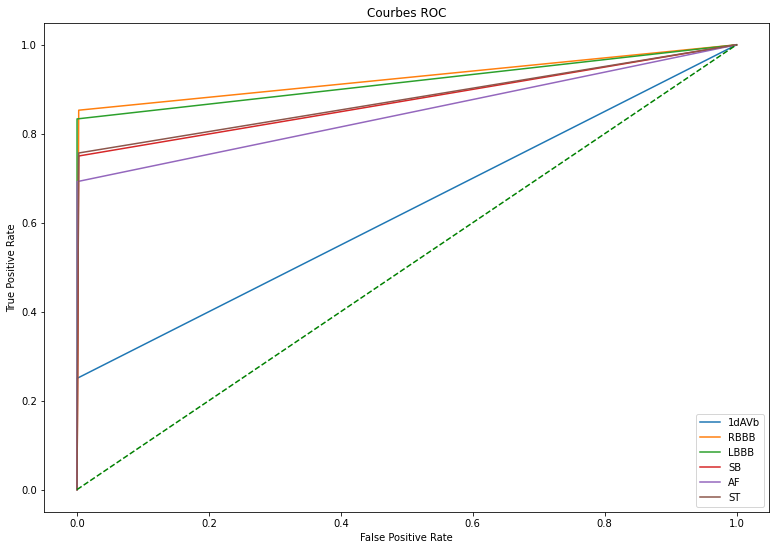

In [19]:
plt.figure(figsize=(13,9))

fper1, tper1, thresholds = roc_curve(df_gold_s.iloc[:,0],df_predictions_arrondies.iloc[:,0])
fper2, tper2, thresholds = roc_curve(df_gold_s.iloc[:,1],df_predictions_arrondies.iloc[:,1])
fper3, tper3, thresholds = roc_curve(df_gold_s.iloc[:,2],df_predictions_arrondies.iloc[:,2])
fper4, tper4, thresholds = roc_curve(df_gold_s.iloc[:,3],df_predictions_arrondies.iloc[:,3])
fper5, tper5, thresholds = roc_curve(df_gold_s.iloc[:,4],df_predictions_arrondies.iloc[:,4])
fper6, tper6, thresholds = roc_curve(df_gold_s.iloc[:,5],df_predictions_arrondies.iloc[:,5])

plt.plot(fper1, tper1, label='1dAVb')
plt.plot(fper2, tper2, label='RBBB')
plt.plot(fper3, tper3, label='LBBB')
plt.plot(fper4, tper4, label='SB')
plt.plot(fper5, tper5, label='AF')
plt.plot(fper6, tper6, label='ST')

plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbes ROC')
plt.legend()
plt.show()

Ci-dessus la courbe ROC de notre classifieur pour chaque anomalie. Elle confirme ce que l'on avait vu précédemment avec les matrices de confusion : il fait peu d'erreur sauf pour 1dAVb où la détection d'anomalie semble plus compliquée.

Nous affichons ci-dessous les courbes pour chaque prédiction que nous avons:

In [20]:

## permet de transformer les données pour qu'elles soient traitables par les fonctions de keras
def stats2(df):
    gold_new=np.zeros(827)
    df_new=np.zeros(827)
    score=0
    for idy in range(6):
        for idx in range(827):
            if df.values[idx,idy]==1:
                df_new[idx]=1
            if df_gold_s.values[idx,idy]==1 or df_gold_s.values[idx,idy]==2:
                gold_new[idx]=1
    
    for i in range(827):
        if gold_new[i]==df_new[i]:
            score+=1

    return score/(827),df_new,gold_new

df_cardio1_global=stats2(df_cardio1)[1]
df_cardio2_global=stats2(df_cardio2)[1]
df_cardior_global=stats2(df_cardior)[1]
df_dnn_global=stats2(df_dnn)[1]
df_emergency_global=stats2(df_emergency)[1]
df_students_global=stats2(df_students)[1]
df_predictions_arrondies_global=stats2(df_predictions_arrondies)[1]
df_gold_s_global=stats2(df_cardio1)[2]

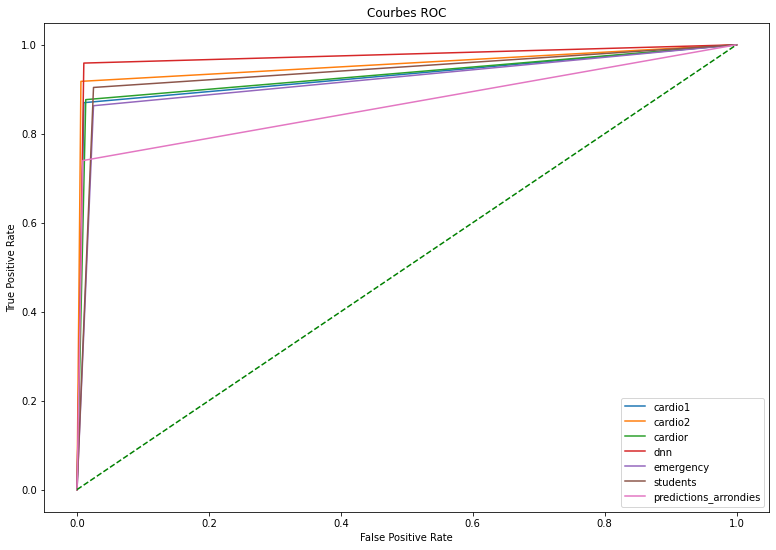

AUC predictions: 0.8654577273550177


In [22]:
plt.figure(figsize=(13,9))

fper1, tper1, thresholds = roc_curve(df_gold_s_global,df_cardio1_global)
fper2, tper2, thresholds = roc_curve(df_gold_s_global,df_cardio2_global)
fper3, tper3, thresholds = roc_curve(df_gold_s_global,df_cardior_global)
fper4, tper4, thresholds = roc_curve(df_gold_s_global,df_dnn_global)
fper5, tper5, thresholds = roc_curve(df_gold_s_global,df_emergency_global)
fper6, tper6, thresholds = roc_curve(df_gold_s_global,df_students_global)
fper7, tper7, thresholds = roc_curve(df_gold_s_global,df_predictions_arrondies_global)


plt.plot(fper1, tper1, label='cardio1')
plt.plot(fper2, tper2, label='cardio2')
plt.plot(fper3, tper3, label='cardior')
plt.plot(fper4, tper4, label='dnn')
plt.plot(fper5, tper5, label='emergency')
plt.plot(fper6, tper6, label='students')
plt.plot(fper7, tper7, label='predictions_arrondies')


plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbes ROC')
plt.legend()
plt.show()

print("AUC predictions: " + str(roc_auc_score(df_gold_s_global, df_predictions_arrondies_global )))

Selon la courbe ROC ci-dessus, le réseau de neurone de Nature est le meilleur classifieur, devant tous les autres. Notre classifieur est le moins bon, mais sa courbe a tout de même une très bonne allure, avec une AUC d'environ $0.86$.\
Néanmoins, étant face à des données très désequilibrées, une courbe ROC ne suffit pas. Cela provient du fait que la sensitivité et la spécificité qui composent la courbe ROC sont des probabilités conditionnées sur la classe positive. Ainsi, elles resteront les mêmes sans se soucier de la valeur de la probabilité d'avoir un positif. Ce n'est pas le cas avec la précision qui est conditionnée sur l'estimation d'avoir un positif.

On affiche donc les courbes PR.

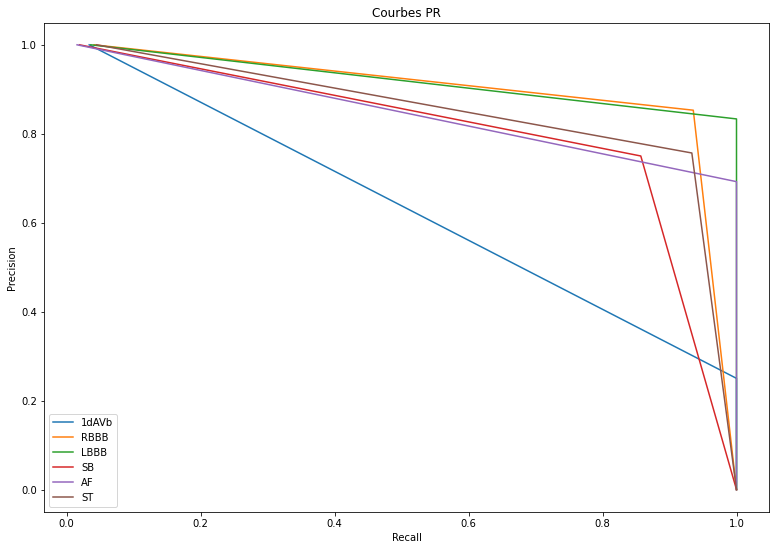

In [27]:
plt.figure(figsize=(13,9))

fper1, tper1, thresholds = precision_recall_curve(df_gold_s.iloc[:,0],df_predictions_arrondies.iloc[:,0])
fper2, tper2, thresholds = precision_recall_curve(df_gold_s.iloc[:,1],df_predictions_arrondies.iloc[:,1])
fper3, tper3, thresholds = precision_recall_curve(df_gold_s.iloc[:,2],df_predictions_arrondies.iloc[:,2])
fper4, tper4, thresholds = precision_recall_curve(df_gold_s.iloc[:,3],df_predictions_arrondies.iloc[:,3])
fper5, tper5, thresholds = precision_recall_curve(df_gold_s.iloc[:,4],df_predictions_arrondies.iloc[:,4])
fper6, tper6, thresholds = precision_recall_curve(df_gold_s.iloc[:,5],df_predictions_arrondies.iloc[:,5])

plt.plot(fper1, tper1, label='1dAVb')
plt.plot(fper2, tper2, label='RBBB')
plt.plot(fper3, tper3, label='LBBB')
plt.plot(fper4, tper4, label='SB')
plt.plot(fper5, tper5, label='AF')
plt.plot(fper6, tper6, label='ST')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbes PR')
plt.legend()
plt.show()



Ces courbes PR confirment ce que nous pensions auparavant : notre classifieur a du mal à classifier les anomalies, notamment pour 1dAVb.

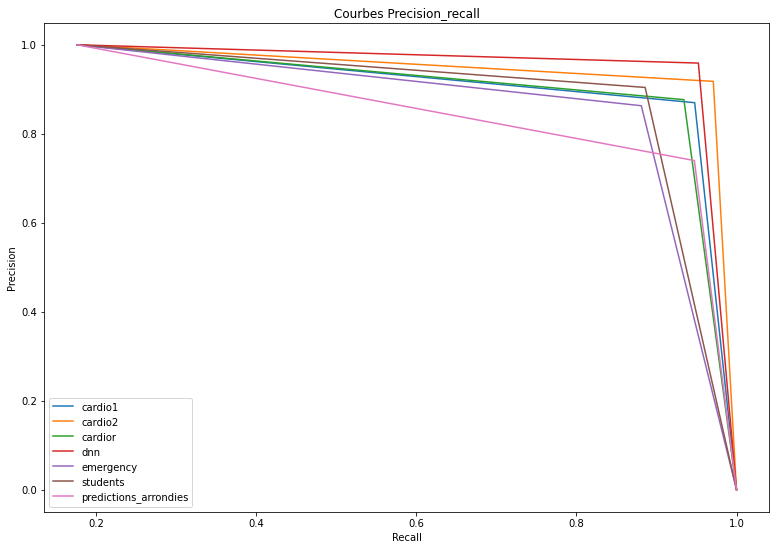

AUC predictions: 0.7467422926134804


In [28]:
plt.figure(figsize=(13,9))
pr1, rec1, thresholds = precision_recall_curve(df_gold_s_global,df_cardio1_global)
pr2, rec2, thresholds = precision_recall_curve(df_gold_s_global,df_cardio2_global)
pr3, rec3, thresholds = precision_recall_curve(df_gold_s_global,df_cardior_global)
pr4, rec4, thresholds = precision_recall_curve(df_gold_s_global,df_dnn_global)
pr5, rec5, thresholds = precision_recall_curve(df_gold_s_global,df_emergency_global)
pr6, rec6, thresholds = precision_recall_curve(df_gold_s_global,df_students_global)
pr7, rec7, thresholds = precision_recall_curve(df_gold_s_global,df_predictions_arrondies_global)

plt.plot(pr1, rec1, label='cardio1')
plt.plot(pr2, rec2, label='cardio2')
plt.plot(pr3, rec3, label='cardior')
plt.plot(pr4, rec4, label='dnn')
plt.plot(pr5, rec5, label='emergency')
plt.plot(pr6, rec6, label='students')
plt.plot(pr7, rec7, label='predictions_arrondies')



plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbes Precision_recall')
plt.legend()
plt.show()

print("AUC predictions: " + str(average_precision_score(df_gold_s_global, df_predictions_arrondies_global )))

La courbe PR de notre classifieur a une bonne allure, mais est moins bonne que les autres. On remarque une AUC de 0.74, ce qui moins bien que pour la courbe ROC, et nous montre bien qu'il a du mal à diagnostiquer les anomalies.

En conclusion, on peut dire que notre classfieur est bon, il a un bon score, et n'est pas loin des prédictions des spécialistes du domaine. Cependant, on a pu voir qu'il avait du mal à diagnostiquer les anomalies notamment pour la 1dAVb. Pour corriger cela, on pourrait rajouter un biais qui forcerait le classifieur à plus prendre en compte certaines caractéristiques des ECG lors de l'entraînement (à définir avec un spécialiste), afin de mieux les diagnostiquer.